In [2]:
import gc, argparse, sys, os, errno
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy
import sklearn
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [3]:
cd ..

/Users/james/Desktop/四春/A5图像处理/大作业2/DIP_final


In [6]:
ls output/models/crlr

0/          CRLR_betas/ J_loss.txt  beta.txt
1/          CRLR_ws/    W.txt


In [58]:
beta_path = 'output/models/crlr/CRLR_betas/'
w_path = 'output/models/crlr/CRLR_ws/'

In [59]:
betas = {}
W = {}
for i in range(10):
    betas[i] = np.load(beta_path+'beta'+str(i)+'.npy')
    W[i] = np.load(w_path+'w'+str(i)+'.npy')

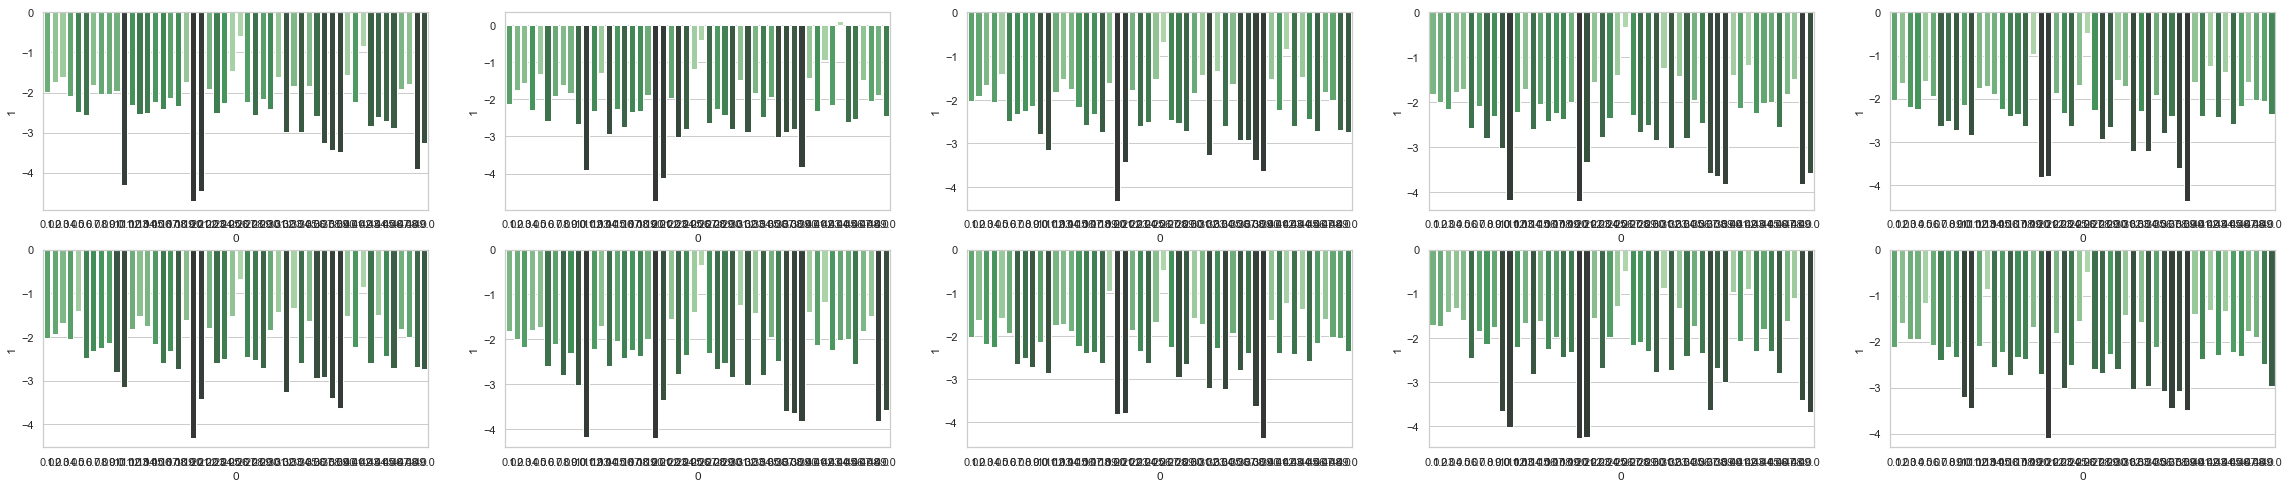

In [57]:
beta_num = betas[i+j*2].shape[0]
pal = sns.color_palette("Greens_d", beta_num)
fig,ax=plt.subplots(2,5,figsize=(40,8))
for i in range(5):
    for j in range(2):
        rank = np.abs(betas[i+j*2]).ravel().argsort().argsort()  
        sns.barplot(data=pd.DataFrame(np.concatenate((np.arange(0,beta_num).reshape(-1,1),
                                              betas[i+j*2].reshape(-1,1)),axis=1) ),x=0,y=1,
                                             palette=np.array(pal[::-1])[rank],ax=ax[j,i])

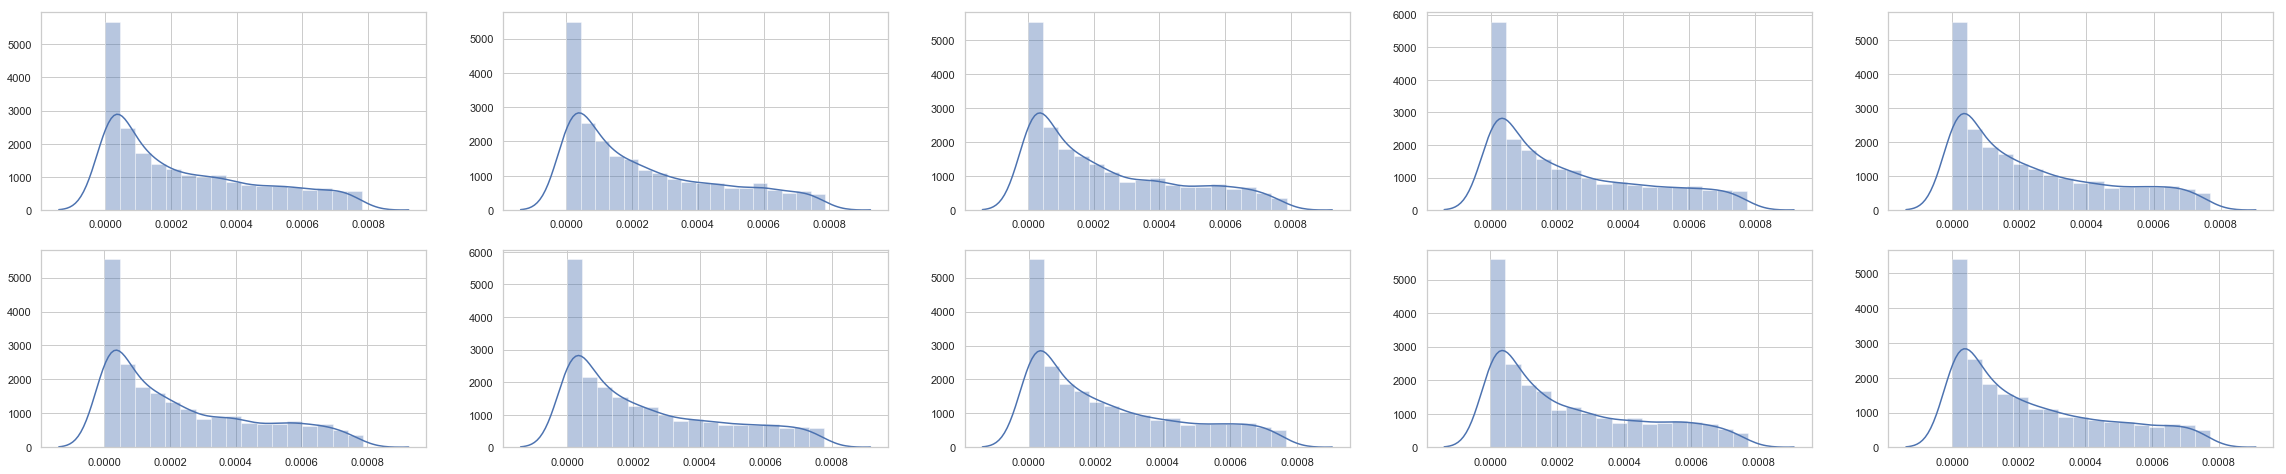

In [64]:
fig,ax=plt.subplots(2,5,figsize=(40,8))
for i in range(5):
    for j in range(2):
        sns.distplot(W[i+j*2],ax=ax[j,i])

In [99]:
W_df = pd.DataFrame(np.concatenate([v for k,v in sorted(W.items())], 1))

In [100]:
W_df.describe()

,0,1,2,3,4,5,6,7,8,9
count,3.556000e+03,3.556000e+03,3.556000e+03,3.556000e+03,3.556000e+03,3.556000e+03,3.556000e+03,3.556000e+03,3.556000e+03,3.556000e+03
mean,2.438938e-04,2.396413e-04,2.393046e-04,2.424239e-04,2.391140e-04,2.386025e-04,2.412248e-04,2.420386e-04,2.421412e-04,2.410885e-04
std,2.280956e-04,2.236750e-04,2.243276e-04,2.271892e-04,2.217144e-04,2.226347e-04,2.225026e-04,2.228686e-04,2.263446e-04,2.247004e-04
min,5.280616e-12,2.131151e-10,1.615278e-10,1.552436e-10,2.398389e-12,1.108797e-10,6.330703e-12,6.861292e-11,8.138504e-12,1.876363e-11
25%,4.250468e-05,4.705574e-05,4.340084e-05,4.150404e-05,4.494936e-05,4.314460e-05,4.657606e-05,4.441251e-05,4.248043e-05,4.285342e-05
50%,1.667415e-04,1.705989e-04,1.664628e-04,1.692371e-04,1.681941e-04,1.625962e-04,1.723454e-04,1.757991e-04,1.712509e-04,1.702374e-04
75%,4.053146e-04,3.951526e-04,3.997386e-04,4.063116e-04,3.962504e-04,4.061046e-04,3.975066e-04,4.117499e-04,3.998416e-04,4.030036e-04
max,7.823297e-04,7.866397e-04,7.876946e-04,7.758624e-04,7.668663e-04,7.698241e-04,7.732842e-04,7.643389e-04,7.915583e-04,7.809662e-04


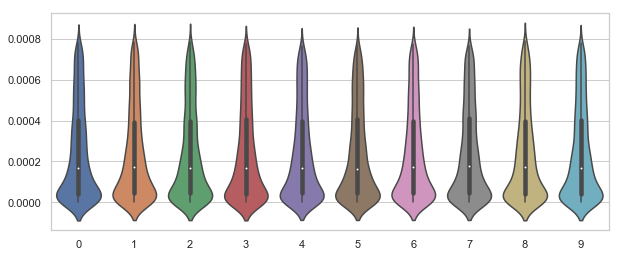

In [101]:
fig,ax=plt.subplots(1,figsize=(10,4))
sns.violinplot(data=W_df,ax=ax)

W_df['index'] = W_df.index
W_df_all = W_df.melt(id_vars=['index'])
W_df_all.head()